In [67]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from hessian_utils import *
from PyHessian.pyhessian.utils import *
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
# from keras.datasets import mnist
import matplotlib.pyplot as plt 
import time
import copy


# PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
# How to do this?
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
%matplotlib inline

In [68]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
cuda = torch.cuda.is_available()

cpu


In [69]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
# Getting mnist test data
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transforms.ToTensor())
mnist_fashion_testset = datasets.FashionMNIST(root='./data/fashion_mnist', train=False, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

Files already downloaded and verified
Files already downloaded and verified


In [70]:
train_X = mnist_trainset.data
train_y = mnist_trainset.targets
test_X = mnist_testset.data
test_y = mnist_testset.targets

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(16*8*8, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16*8*8)
        x = self.linear(x)
        return x


def hess_rand(hess : hessian, model : nn.Module, randvecs, k : int = 100, seed : int = None):
    gradsH = hess.gradsH
    params = hess.params
    if seed is not None:
        torch.manual_seed(seed)
    # We need to calculate R^T * H * R
    #randvecs = [[torch.randn_like(p) for p in params] for _ in range(k)]
    h_r = [hessian_vector_product(gradsH, params, vec) for vec in randvecs]
    h_r_flat = torch.stack([torch.cat([v.view(-1) for v in vec]) for vec in h_r])
    r_t_flat = torch.stack([torch.cat([v.view(-1) for v in vec]) for vec in randvecs])    
    # H_k = torch.zeros((k, k), device = params[0].device)
    # for i in range(k):
    #     for j in range(k):
    #         H_k[i, j] = torch.dot(r_t_flat[i], h_r_flat[j])
    H_k = torch.matmul(r_t_flat, h_r_flat.T) / k
    return H_k


    

In [72]:
train_X = (train_X / 255.0).to(device)
test_X = (test_X / 255.0).to(device)
train_y = torch.tensor(train_y, dtype=torch.int64).to(device)
test_y = torch.tensor(test_y, dtype=torch.int64).to(device)
val_x = train_X[:1000]
val_y = train_y[:1000]
x_samples = train_X[:50]
y_samples = train_y[:50]

C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_22280\1569730334.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y, dtype=torch.int64).to(device)
C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_22280\1569730334.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(test_y, dtype=torch.int64).to(device)


In [73]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X[:1000], train_y[:1000]),
    batch_size=32, shuffle=True)
hessian_loader = []
# hessian_loader contains all 1000 images

for i in range(50):
    hessian_loader.append((train_X[i].unsqueeze(0), train_y[i].unsqueeze(0)))

In [74]:
len(hessian_loader)

50

In [ ]:
model_SGD = Net().to(device)
model_Adam = copy.deepcopy(model_SGD)
model_randnewt = copy.deepcopy(model_SGD)
criterion = nn.CrossEntropyLoss()
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=1)
optimizer_Adam = torch.optim.Adam(model_Adam.parameters(), lr=1e-2)
optimizer_randnewt = torch.optim.SGD(model_randnewt.parameters(), lr=1)

In [76]:
train_losses_SGD = []
train_losses_Adam = []
train_losses_randnewt = []
traces_SGD = []
traces_Adam = []
traces_randnewt = []
epochs = 15
k = 100

hessian_sgd = hessian(model_SGD, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_adam = hessian(model_Adam, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_randnewt = hessian(model_randnewt, criterion, dataloader=hessian_loader, cuda=cuda)
traces_SGD.append(np.mean(hessian_sgd.trace()))
traces_Adam.append(np.mean(hessian_adam.trace()))
traces_randnewt.append(np.mean(hessian_randnewt.trace()))

In [77]:
for epoch in range(epochs):
    model_SGD.train()
    model_Adam.train()
    model_randnewt.train()

    for i, (x, y) in enumerate(dataloader):
        optimizer_SGD.zero_grad()
        optimizer_Adam.zero_grad()
        #optimizer_randnewt.zero_grad()
        model_randnewt.zero_grad()
        y_pred_SGD = model_SGD(x)
        y_pred_Adam = model_Adam(x)
        y_pred_randnewt = model_randnewt(x)
        loss_SGD = criterion(y_pred_SGD, y)
        loss_Adam = criterion(y_pred_Adam, y)
        loss_randnewt = criterion(y_pred_randnewt, y)
        loss_SGD.backward()
        loss_Adam.backward()
        loss_randnewt.backward()
        optimizer_SGD.step()
        optimizer_Adam.step()
        #optimizer_randnewt.step()
        # Randomized Newton Step
        randvecs = []
        for _ in range(k):
            vec = orthnormal([torch.randn_like(p) for p in model_randnewt.parameters()], randvecs)
            randvecs.append(vec)

        hessian_randnewt = hessian(model_randnewt, criterion, data = (x, y), cuda=cuda)
        grad_vec = [param.grad for param in model_randnewt.parameters()]
        H_k = hess_rand(hessian_randnewt, model_randnewt, randvecs, k=k)
        H_k_inv = torch.linalg.pinv(H_k + 1e-4 * torch.eye(k, device=H_k.device))
        grad_vec_flat = torch.cat([v.view(-1) for v in grad_vec])
        flat_randvecs = [torch.cat([v.view(-1) for v in vec]) for vec in randvecs]
        R = torch.stack(flat_randvecs)
        g_k = R @ grad_vec_flat  # Shape: (k,)

        # Update:
        delta = H_k_inv @ g_k
        update = R.t() @ delta
        
        offset = 0
        for param in model_randnewt.parameters():
            param.data -= 0.5e-2* update[offset:offset+param.numel()].view(param.shape)
            offset += param.numel()
        
        train_losses_SGD.append(loss_SGD.item())
        train_losses_Adam.append(loss_Adam.item())
        train_losses_randnewt.append(loss_randnewt.item())
        print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(dataloader)}, Loss_SGD: {loss_SGD.item()}, Loss_Adam: {loss_Adam.item()}, Loss_randnewt: {loss_randnewt.item()}")
    hessian_sgd = hessian(model_SGD, criterion, dataloader=hessian_loader, cuda=cuda)
    hessian_adam = hessian(model_Adam, criterion, dataloader=hessian_loader, cuda=cuda)
    hessian_randnewt = hessian(model_randnewt, criterion, dataloader=hessian_loader, cuda=cuda)
    traces_SGD.append(np.mean(hessian_sgd.trace()))
    traces_Adam.append(np.mean(hessian_adam.trace()))
    traces_randnewt.append(np.mean(hessian_randnewt.trace()))
    print(f"Epoch {epoch+1}/{epochs}, Trace_SGD: {traces_SGD[-1]}, Trace_Adam: {traces_Adam[-1]}, Trace_randnewt: {traces_randnewt[-1]}")

Epoch 1/15, Batch 1/32, Loss_SGD: 2.3352575302124023, Loss_Adam: 2.3352575302124023, Loss_randnewt: 2.3352575302124023
Epoch 1/15, Batch 2/32, Loss_SGD: 2.1126530170440674, Loss_Adam: 2.032815933227539, Loss_randnewt: 2.2776036262512207
Epoch 1/15, Batch 3/32, Loss_SGD: 2.2876243591308594, Loss_Adam: 2.256945848464966, Loss_randnewt: 2.290983200073242
Epoch 1/15, Batch 4/32, Loss_SGD: 2.065946340560913, Loss_Adam: 1.7056599855422974, Loss_randnewt: 2.2297239303588867
Epoch 1/15, Batch 5/32, Loss_SGD: 1.8119558095932007, Loss_Adam: 1.4888800382614136, Loss_randnewt: 2.2215394973754883
Epoch 1/15, Batch 6/32, Loss_SGD: 2.0757906436920166, Loss_Adam: 1.580225944519043, Loss_randnewt: 2.2248759269714355
Epoch 1/15, Batch 7/32, Loss_SGD: 1.7908754348754883, Loss_Adam: 1.3258225917816162, Loss_randnewt: 2.1634113788604736
Epoch 1/15, Batch 8/32, Loss_SGD: 1.659623146057129, Loss_Adam: 1.1593607664108276, Loss_randnewt: 2.1392452716827393
Epoch 1/15, Batch 9/32, Loss_SGD: 1.4401441812515259, 

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix contained non-finite values.

c:\Users\Rajeev Wankar\Desktop\Aarsh IITGN\Project Course - Sem 4\DeepHessian\PyHessian\density_plot.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


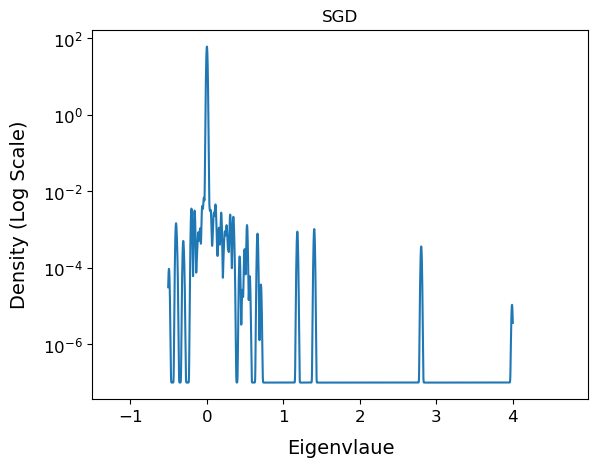

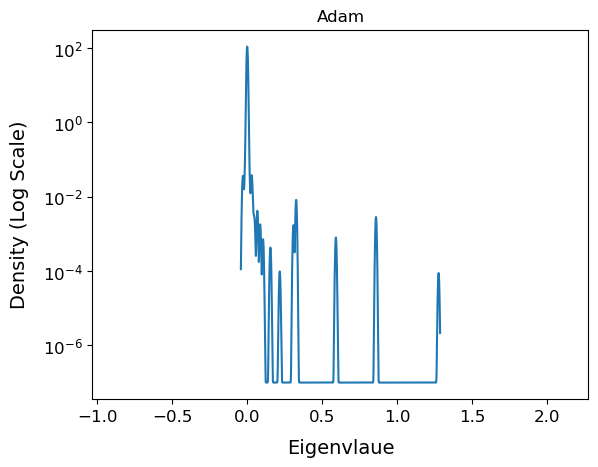

RuntimeError: torch.linalg.eig: input tensor should not contain infs or NaNs.

In [78]:
hessian_sgd = hessian(model_SGD, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_adam = hessian(model_Adam, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_randnewt = hessian(model_randnewt, criterion, dataloader=hessian_loader, cuda=cuda)
get_esd_plot(*hessian_sgd.density(), title='SGD')
get_esd_plot(*hessian_adam.density(), title='Adam')
get_esd_plot(*hessian_randnewt.density(), title='Random Projection')
plt.show()

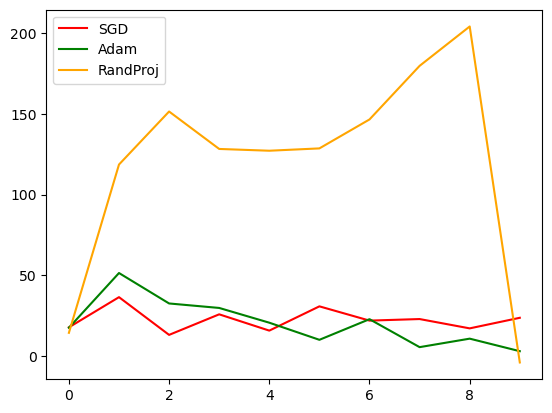

In [79]:
plt.plot(traces_SGD, label='SGD', c="r")
plt.plot(traces_Adam, label='Adam', c="g")
plt.plot(traces_randnewt, label='RandProj', c="orange")
plt.legend()
plt.show()

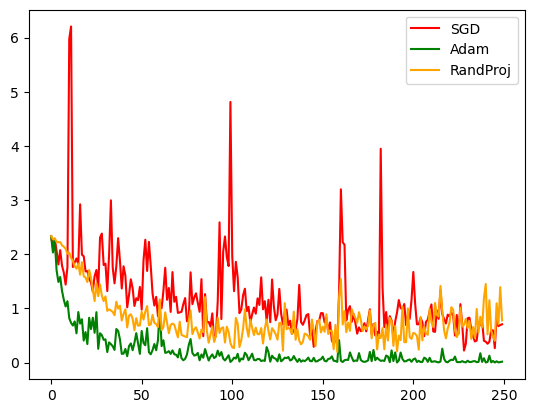

In [82]:
plt.plot(train_losses_SGD[:250], label='SGD', c="r")
plt.plot(train_losses_Adam[:250], label='Adam', c="g")
plt.plot(train_losses_randnewt[:250], label='RandProj', c="orange")
plt.legend()

In [91]:
lrs = [1e-4, 5e-4, 1e-3, 1.5e-3, 2e-3, 2.5e-3, 3e-3, 3.5e-3, 4e-3]
model_sketch = Net().to(device)
sketch_models = [copy.deepcopy(model_sketch) for _ in range(len(lrs))]
lr_losses = [[] for _ in range(len(lrs))]
lr_traces = [[] for _ in range(len(lrs))]

all_hessians = [hessian(model, criterion, dataloader=hessian_loader, cuda=cuda) for model in sketch_models]
for i, hessian_sketch in enumerate(all_hessians):
    lr_traces[i].append(np.mean(hessian_sketch.trace()))

criterion = nn.CrossEntropyLoss()

In [ ]:
for i in range(len(lrs)):
    lr = lrs[i]
    model_sk = sketch_models[i]
    for epoch in range(epochs):
        for j, (x, y) in enumerate(dataloader):
            #optimizer_sk.zero_grad()
            model_sk.zero_grad()
            y_pred_sk = model_sk(x)
            loss_sk = criterion(y_pred_sk, y)
            loss_sk.backward()
            # Randomized Newton Step
            randvecs = []
            for _ in range(k):
                vec = orthnormal([torch.randn_like(p) for p in model_sk.parameters()], randvecs)
                randvecs.append(vec)

            hessian_sk = hessian(model_sk, criterion, data = (x, y), cuda=cuda)
            grad_vec = [param.grad for param in model_sk.parameters()]
            H_k = hess_rand(hessian_sk, model_sk, randvecs, k=k)
            H_k_inv = torch.linalg.pinv(H_k + 1e-4 * torch.eye(k, device=H_k.device))
            grad_vec_flat = torch.cat([v.view(-1) for v in grad_vec])
            flat_randvecs = [torch.cat([v.view(-1) for v in vec]) for vec in randvecs]
            R = torch.stack(flat_randvecs)
            g_k = R @ grad_vec_flat  # Shape: (k,)

            # Update:
            delta = H_k_inv @ g_k
            update = R.t() @ delta
            
            offset = 0
            for param in model_sk.parameters():
                param.data -= lr* update[offset:offset+param.numel()].view(param.shape)
                offset += param.numel()         
            lr_losses[i].append(loss_sk.item())
            print(f"lr: {lr}, Epoch {epoch+1}/{epochs}, Batch {j+1}/{len(dataloader)}, Loss_sk: {loss_sk.item()}")
        hessian_sk = hessian(model_sk, criterion, dataloader=hessian_loader, cuda=cuda)
        lr_traces[i].append(np.mean(hessian_sk.trace()))
        print(f"lr: {lr}, Epoch {epoch+1}/{epochs}, Trace_sk: {lr_traces[i][-1]}")

lr: 0.0001, Epoch 1/15, Batch 1/32, Loss_sk: 2.287898540496826
lr: 0.0001, Epoch 1/15, Batch 2/32, Loss_sk: 2.327230930328369
lr: 0.0001, Epoch 1/15, Batch 3/32, Loss_sk: 2.2988202571868896
lr: 0.0001, Epoch 1/15, Batch 4/32, Loss_sk: 2.2946248054504395
lr: 0.0001, Epoch 1/15, Batch 5/32, Loss_sk: 2.2900803089141846
lr: 0.0001, Epoch 1/15, Batch 6/32, Loss_sk: 2.3188724517822266
lr: 0.0001, Epoch 1/15, Batch 7/32, Loss_sk: 2.2931931018829346
lr: 0.0001, Epoch 1/15, Batch 8/32, Loss_sk: 2.291550397872925
lr: 0.0001, Epoch 1/15, Batch 9/32, Loss_sk: 2.3077523708343506
lr: 0.0001, Epoch 1/15, Batch 10/32, Loss_sk: 2.3018555641174316
lr: 0.0001, Epoch 1/15, Batch 11/32, Loss_sk: 2.2918481826782227
lr: 0.0001, Epoch 1/15, Batch 12/32, Loss_sk: 2.2975568771362305
lr: 0.0001, Epoch 1/15, Batch 13/32, Loss_sk: 2.298370122909546
lr: 0.0001, Epoch 1/15, Batch 14/32, Loss_sk: 2.308281183242798
lr: 0.0001, Epoch 1/15, Batch 15/32, Loss_sk: 2.3140296936035156
lr: 0.0001, Epoch 1/15, Batch 16/32, Lo

In [ ]:
for i in range(len(lrs)):
    hessian_sk = hessian(sketch_models[i], criterion, dataloader=hessian_loader, cuda=cuda)
    get_esd_plot(*hessian_sk.density(), title=f'Sketch lr={lrs[i]}')
    plt.show()


for i in range(len(lrs)):
    plt.plot(lr_traces[i], label=f'Sketch lr={lrs[i]}')
    plt.title(f'Trace')
    plt.xlabel('Epochs')
    plt.ylabel('Trace')
plt.legend()
plt.show()

for i in range(len(lrs)):
    plt.plot(lr_losses[i], label=f'Sketch lr={lrs[i]}')
    plt.title(f'Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
np.save('lr_losses.npy', np.array(lr_losses))
np.save('lr_traces.npy', np.array(lr_traces))

c:\Users\Rajeev Wankar\Desktop\Aarsh IITGN\Project Course - Sem 4\DeepHessian\PyHessian\density_plot.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


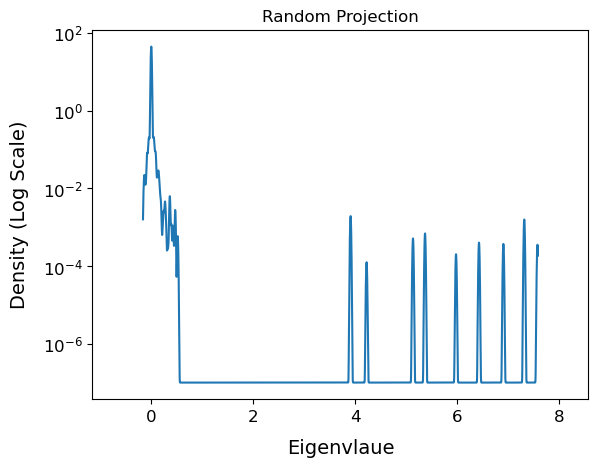

In [150]:
hessian_randnewt = hessian(model_randnewt, criterion, dataloader = hessian_loader, cuda=cuda)
get_esd_plot(*hessian_randnewt.density(), title='Random Projection')

In [153]:
all_x = torch.cat([x for x, _ in hessian_loader])
all_y = torch.cat([y for _, y in hessian_loader])

100


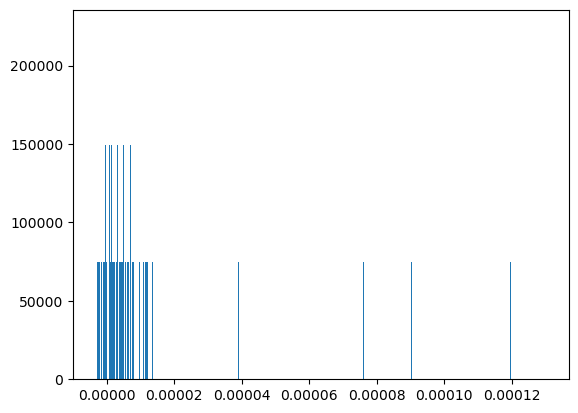

c:\Users\Rajeev Wankar\Desktop\Aarsh IITGN\Project Course - Sem 4\DeepHessian\PyHessian\density_plot.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


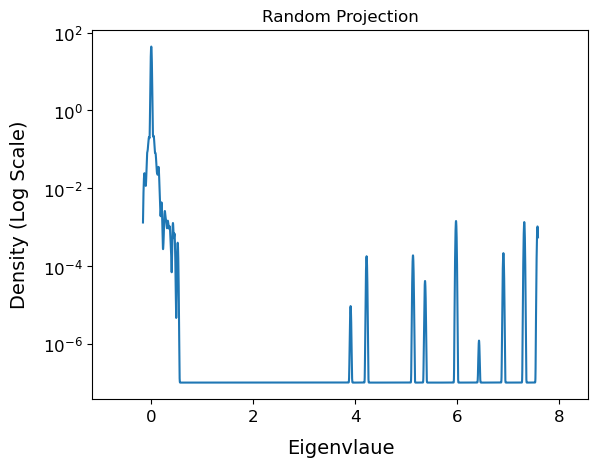

In [154]:
randvecs = []
for _ in range(k):
    vec = orthnormal([torch.randn_like(p) for p in model_randnewt.parameters()], randvecs)
    randvecs.append(vec)
print(len(randvecs))
hessian_randnewt = hessian(model_randnewt, criterion, data = (all_x, all_y), cuda=cuda)
#print(hessian_randnewt.gradsH)
H_k = hess_rand(hessian_randnewt, model_randnewt, randvecs, k=k)
vals, vecs = torch.linalg.eigh(H_k)
#print(vecs)
# ESD of actual vals
plt.hist(vals.cpu().numpy(), bins=1000, density=True)

plt.show()
get_esd_plot(*hessian_randnewt.density(), title='Random Projection')